In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import time
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle
import gzip
import queue as qe
import time
import networkx as nx
from sklearn.linear_model import LinearRegression

# Práctica 1

## Parte 1

In [2]:
l = [[0, 10, 1, np.inf],
[np.inf, 0, 1, np.inf],
[np.inf, np.inf, 0, 1 ],
[np.inf, 1, np.inf, 0]]
m_g = np.array(l)

In [3]:
d_g = {0: {1: 10, 2:1}, 1: {2: 1},
2: {3: 1}, 3: {1: 1}}

In [4]:
m_g,d_g

(array([[ 0., 10.,  1., inf],
        [inf,  0.,  1., inf],
        [inf, inf,  0.,  1.],
        [inf,  1., inf,  0.]]),
 {0: {1: 10, 2: 1}, 1: {2: 1}, 2: {3: 1}, 3: {1: 1}})

In [6]:
def rand_matr_pos_graph(n_nodes, sparse_factor, max_weight=50., decimals=0):
    """
    Funcion que genera grafos de manera aleatoria.
    Devuelve la matriz de adyacencia de un grafo dirigido ponderado.
    
    :param n_nodes: numero de nodos
    :param sparse_factor: proporcion de ramas
    :param max_weight: peso maximo
    :param decimals: numero de decimales
    """
    l = np.full((n_nodes,n_nodes),np.inf)
    branch_number = int(sparse_factor*(n_nodes)*(n_nodes-1))
    for count in range(0,branch_number):
        condition = True
        while(condition):
            i = random.randint(0,n_nodes-1)
            j = random.randint(0,n_nodes-1)
            if(j!=i and l[i,j] == np.inf):
                condition = False         
        weight = random.randint(1,max_weight)
        l[i,j] = weight
    return l

In [7]:
def cuenta_ramas(m_g):
    """
    Funcion que cuenta las ramas de un grafo.
    Devuelve el numero de ramas.
    
    :param m_g: matriz de adyacencia del grafo
    """
    n_nodes = m_g.shape[0]
    branches = 0
    for i in range(0,n_nodes):
        for j in range(0,n_nodes):
            if ((m_g[i,j] != np.inf) and i != j):
                branches+=1
    return branches

In [8]:
def m_g_sparse_factor(m_g):
    """
    Funcion auxiliar de check_sparse_factor.
    Devuelve el calculo de sparse factor de cada grafo.
    
    :param m_g: matriz de adyacencia del grafo
    """
    n_nodes = m_g.shape[0]
    return cuenta_ramas(m_g)/(n_nodes*(n_nodes-1))

def check_sparse_factor(n_grafos,n_nodes,sparse_factor):
    """
    Funcion que genera las matrices de un numero de grafos aleatorios con un numero de nodos y un sparse factor.
    Devuelve la media de los sparse factor reales de las matrices de los grafos generadas.
    
    :param n_grafos: numero de grafos
    :param n_nodes: numero de nodos del grafo
    :param sparse_factor: proporcion de ramas
    """
    sparses = []
    for i in range(0,n_grafos):
        m = rand_matr_pos_graph(n_nodes,sparse_factor)
        sparses.append(m_g_sparse_factor(m))
    return np.mean(sparses)    

In [9]:
def m_g_2_d_g(m_g):
    """
    Funcion que convierte la matriz de adyacencia del grafo en un diccionario.
    Devuelve un diccionario con cada nodo (k) asignado a otro diccionario (v) con los nodos destino (k)
    y el peso relacionado (v).
    
    :param m_g: matriz de adyacencia del grafo
    """
    n_nodes = m_g.shape[0]
    d_g = {}
    for i in range(0,n_nodes):
        d_g[i] = {}
        for j in range(0,n_nodes):
            if(m_g[i,j] != np.inf):
                d_g[i][j] = m_g[i,j]
    return d_g

In [10]:
def d_g_2_m_g(d_g):
    """
    Funcion que convierte el diccionario del grafo a una matriz de adyacencia.
    Devuelve la matriz de adyacencia resultante.
    
    :param d_g: diccionario del grafo
    """
    n_nodes = len(d_g.keys())
    m_g = np.full((n_nodes,n_nodes),np.inf)
    for node in d_g:
        for branch in d_g[node]:
            m_g[node,branch] = d_g[node][branch]
    return m_g

In [11]:
def save_object(obj, f_name="obj.pklz", save_path="."):
    """
    Funcion que guarda un objeto en un dump file.
    Realiza el volcado en cuestion, en este caso, de un grafo.
    
    :param obj: objeto a guardar
    :param f_name: nombre del objeto
    :param save_path: ruta del archivo
    """
    f = gzip.open(save_path+"/"+f_name,"wb")
    pickle.dump(obj,f)
    f.close()

def read_object(f_name, save_path="."):
    """
    Funcion que lee un objeto.
    Devuelve el objeto en cuestion.
    
    :param f_name: nombre del archivo
    :param save_path: ruta del fichero
    """
    f = gzip.open(save_path+"/"+f_name,"rb")
    obj = pickle.load(f)
    f.close()
    return obj

In [24]:
def d_g_2_TGF(d_g,f_name):
    """
    Funcion que pasa un grafo en forma de diccionario a formato TGF.
    
    :param d_g: diccionario
    :param f_name: nombre del fichero donde guardamos el grafo
    """
    f = open(f_name,"w")
    for node in d_g.keys():
        f.write("%d\n" % node)
    f.write("#\n")
    for node in d_g.keys():
        for branch in d_g[node]:
            f.write("{0} {1} {2}\n".format(node, branch, d_g[node][branch]))
    f.close()

In [25]:
def TGF_2_d_g(f_name):
    """
    Funcion que pasa un grafo en formato TGF a un diccionario.
    
    :param f_name: nombre del fichero donde se guardo el grafo
    """
    f = open(f_name,"r")
    line = f.read().split('\n')
    d_g = {}
    aux = []
    for c in line:
        aux.append(c)
        if(c == "#"):
            break
        n = int(c)
        d_g.update({n:{}})
        
    line = line[len(aux):-1]
    for c in line:
        splitted = c.split(" ")
        p1 = int(splitted[1])
        p2 = float(splitted[2])
        d_g[int(splitted[0])].update({p1:p2})
    f.close()
    return d_g
           
n_nodes = 5
sparse = 0.5
m = rand_matr_pos_graph(n_nodes,sparse)
print(m)
dicc = m_g_2_d_g(m)
print("[m_g_2_d_g(m)]:\n", dicc)
dicc[0][2] = 0.5
d_g_2_TGF(dicc,"pepitogrillo.txt")
save_object(dicc)
print("[RES]:\n", TGF_2_d_g("pepitogrillo.txt"))

[[inf 13. inf  2. inf]
 [inf inf inf inf 48.]
 [inf 12. inf inf  4.]
 [28. 50. 10. inf  7.]
 [inf inf inf 16. inf]]
[m_g_2_d_g(m)]:
 {0: {1: 13.0, 3: 2.0}, 1: {4: 48.0}, 2: {1: 12.0, 4: 4.0}, 3: {0: 28.0, 1: 50.0, 2: 10.0, 4: 7.0}, 4: {3: 16.0}}
[RES]:
 {0: {1: 13.0, 3: 2.0, 2: 0.5}, 1: {4: 48.0}, 2: {1: 12.0, 4: 4.0}, 3: {0: 28.0, 1: 50.0, 2: 10.0, 4: 7.0}, 4: {3: 16.0}}


### Cuestiones

**Describir que se entiende por serializar un objeto Python.**

Serializar un objeto es el proceso de convertirlo a un formato específico mediante el cual pueda ser almacenado en disco de forma persistente y posteriormente cargado desde el fichero en el mismo estado en el que se guardó.

**json es otro formato de serialiacion de objetos. Comentar brevemente posibles diferencias entre pickle y json.**

La diferencia principal entre pickle y json es que pickle guarda los objetos en binario mientras que json guarda los objetos de forma legible mediante atributos->valor.
Un ejemplo de pickle para guardar la lista [1,2,3,4] sería:
```
�]q (KKKKe.
```
Y en JSON podría ser por ejemplo
```json
{
    lista: [1,2,3,4]
}
```

**¿Que ventajas e inconvenientes tendrían las funciones pickle sobre las construidas mediante el formato TGF? Responder algo pertinente y no con lugares comunes.**

    * Ventajas:
        1. La escritura y lectura es más rápida ya que se escribe el objeto directamente y no es necesario procesarlo para su escritura ni lectura.
        2. La forma de escritura y lectura de pickle es mucho más sencilla que la escritura-lectura en formato TGF, ya que para escribir y leer en este formato es necesario procesar el grafo e ir escribiendo en el formato adecuado mientras que pickle vuelca el objeto directamente.
        3. El formato de pickle es más seguro ya que al guardar la información en binario, no puede ser accedida por cualquier persona en cualquier momento.

    * Desventajas: 
        1. No es legible para personas el fichero escrito, por lo que para leerlo es necesario utilizar la librería pickle junto con un script de Python.
        2. El formato TGF ocupa menos espacio en disco que el formato pickle (para un mismo grafo pequeño de ejemplo, el objeto en formato TGF ocupa 107 bytes y en formato pickle y comprimido, ocupa 272 bytes) . Esto para grafos grandes y a nivel de rendimiento, podría suponer un gran problema de almacenamiento.
        3. Pickle, al ser una librería de Python, hace que los grafos volcados a través de ella no sean accesibles a través de programas escritos en otros lenguajes.


In [27]:
def dijkstra_d(d_g, u):
    """
    Funcion que aplica el algoritmo de Dijkstra a un grafo en formato de diccionario a partir de un nodo inicial.
    Devuelve un diccionario con las distancias mínimas al resto de nodos y otro que contiene el padre correspondiente
    a cada vértice accesible.
    
    :param d_g: diccionario
    :param u: nodo inicial
    """
    d_dist = {}
    d_prev = {}
    
    dist = np.full(len(d_g.keys()), np.inf)
    visitados = np.full(len(d_g.keys()), False)
    n_padre = np.full(len(d_g.keys()), None)
    
    cola = qe.PriorityQueue()
    dist[u] = 0.0
    cola.put((0.0, u))
    
    while not cola.empty():
        pos = cola.get()
        visitados[pos[1]] = True
        
        for key,value in d_g[pos[1]].items():
            if dist[key] > dist[pos[1]] + value:
                dist[key] = dist[pos[1]] + value
                n_padre[key] = pos[1]
                cola.put((dist[key], key))
   
    for n in range(len(dist)):
        d_dist.update({n:dist[n]})
        d_prev.update({n:n_padre[n]})
        
    return d_dist, d_prev

def dijkstra_m(m_g,u):
    """
    Funcion que aplica el algoritmo de Dijkstra a un grafo en formato de matriz de adyacencia a partir de un nodo inicial.
    Devuelve un diccionario con las distancias mínimas al resto de nodos y otro que contiene el padre correspondiente
    a cada vértice accesible.
    
    :param m_g: matriz de adyacencia
    :param u: nodo inicial
    """
    d_dist = {}
    d_prev = {}
    
    n_nodos = m_g.shape[0]
    dist = np.full(n_nodos, np.inf)
    visitados = np.full(n_nodos, False)
    n_padre = np.full(n_nodos, None)
    
    cola = qe.PriorityQueue()
    dist[u] = 0.0
    cola.put((0.0, u))
    
    while not cola.empty():
        pos = cola.get()
        nodo = pos[1]
        visitados[nodo] = True
        
        for adyacente in range(0,n_nodos):
            if(m_g[nodo,adyacente] != np.inf):
                if dist[adyacente] > dist[nodo] + m_g[nodo,adyacente]:
                    dist[adyacente] = dist[nodo] + m_g[nodo,adyacente]
                    n_padre[adyacente] = nodo
                    cola.put((dist[adyacente], adyacente))
            
    for n in range(len(dist)):
        d_dist.update({n:dist[n]})
        d_prev.update({n:n_padre[n]})
        
    return d_dist, d_prev


d_g = {0: {1: 10, 2:1}, 1: {2: 1,3:2}, 2: {3: 1}, 3: {1: 1, 0:1}}
m_g = d_g_2_m_g(d_g)

d,p = dijkstra_d(d_g,0)
print(dijkstra_m(m_g,0))


({0: 0.0, 1: 3.0, 2: 1.0, 3: 2.0}, {0: None, 1: 3, 2: 0, 3: 2})


In [30]:
def min_paths(d_prev):
    """
    Funcion que devuelve el diccionario con el camino minimo desde el nodo inicial a otro nodo
    
    :param d_prev: diccionario que contiene el padre correspondiente a cada vértice accesible.
    """
    inicial = -1
    for key in d_prev:
        if(d_prev[key] == None):
            inicial = key
    if(inicial == -1):
        raise Exception("La lista de padres no contiene un nodo inicial con padre = None")
    d_paths = {}
    for nodo in d_prev:
        path = []
        condicion = True
        
        nodo_padre = nodo
        while(condicion):
            if(nodo_padre == None):
                path.reverse()
                d_paths[nodo] = path
                condicion = False
            else:
                path.append(nodo_padre)
                nodo_padre = d_prev[nodo_padre]
    return d_paths

In [31]:
mm = np.array([
[0, 1., 1., 1., np.inf, np.inf, np.inf],
[np.inf, 0., np.inf, 1., 1., np.inf, np.inf],
[np.inf, np.inf, 0., np.inf, np.inf, 1., np.inf],
[np.inf, np.inf, 1., 0., np.inf, 1., 1.],
[np.inf, np.inf, np.inf, 1., 0., np.inf, 1.],
[np.inf, np.inf, np.inf, np.inf, np.inf, 0., 1.],
[np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 0.]    
])

dd = m_g_2_d_g(mm)
d, p = dijkstra_d(dd, 0)
min_paths(p)

{0: [0],
 1: [0, 1],
 2: [0, 2],
 3: [0, 3],
 4: [0, 1, 4],
 5: [0, 2, 5],
 6: [0, 3, 6]}

In [32]:
def time_dijkstra_m(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Funcion que calcula el tiempo de aplicar Dijkstra a un grafo dado en formato de matriz de adyacencia.
    Devuelve una lista de tiempos para cada grafo al que se le ha aplicado el algoritmo.
    
    :param n_graphs: numero de grafos a generar
    :param n_nodes_ini: num de nodos inicial
    :param n_nodes_fin: num de nodos final
    :param step: incremento
    :param sparse_factor: factor proporcion de ramas
    """
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            m_g = rand_matr_pos_graph(n_nodos, sparse_factor)
            diccionario_grafos[n_nodos].append(m_g)
   
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                dijkstra_m(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin)

    return lista_tiempos
            
print(time_dijkstra_m(100,1,5,1))
    

[0.0050470829010009766, 0.013557910919189453, 0.017993927001953125, 0.030833959579467773, 0.0370330810546875]


In [33]:
def time_dijkstra_d(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Funcion que calcula el tiempo de aplicar Dijkstra a un grafo dado en formato diccionario.
    Devuelve una lista de tiempos para cada grafo al que se le ha aplicado el algoritmo.
    
    :param n_graphs: numero de grafos a generar
    :param n_nodes_ini: num de nodos inicial
    :param n_nodes_fin: num de nodos final
    :param step: incremento
    :param sparse_factor: factor proporcion de ramas
    """
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            d_g = m_g_2_d_g(rand_matr_pos_graph(n_nodos, sparse_factor))
            diccionario_grafos[n_nodos].append(d_g)
           
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                dijkstra_d(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin)

    return lista_tiempos
            
print(time_dijkstra_d(100,1,5,1))

[0.0062351226806640625, 0.009593963623046875, 0.013876914978027344, 0.026294708251953125, 0.03821682929992676]


In [19]:
def d_g_2_nx_g(d_g):
    """
    Funcion que pasa un grafo en formato de diccionario a otro de Networkx.
    
    :param d_g: diccionario
    """
    l_e = []
    g = nx.DiGraph()
    
    for key,value in d_g.items():
        for key2,value2 in value.items():
            l_e.append((key,key2,value2))
            
    g.add_weighted_edges_from(l_e)
    return g

In [34]:
def nx_g_2_d_g(nx_g):
    """
    Funcion que pasa un grafo en formato Networkx a otro en formato diccionario.
    
    :param nx_g: grafo en formato Networkx
    """
    d_g = {}
    
    for count in nx_g.nodes():
        for key,value in nx_g[count].items():
            if d_g.get(count) == None:
                d_g.update({count:{}})
            for key2,value2 in value.items():
                d_g[count][key]=value2
    
    return d_g

d_g = {0: {1: 10, 2:1}, 1: {2: 1},
2: {3: 1}, 3: {1: 1}}

print(d_g)

nxg = d_g_2_nx_g(d_g)

d_g2 = nx_g_2_d_g(nxg)
print(d_g2)
            

{0: {1: 10, 2: 1}, 1: {2: 1}, 2: {3: 1}, 3: {1: 1}}
{0: {1: 10, 2: 1}, 1: {2: 1}, 2: {3: 1}, 3: {1: 1}}


In [21]:
def time_dijkstra_nx(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Funcion que calcula el tiempo de aplicar Dijkstra a un grafo dado en formato de Networkx.
    Devuelve una lista de tiempos para cada grafo al que se le ha aplicado el algoritmo.
    
    :param n_graphs: numero de grafos a generar
    :param n_nodes_ini: num de nodos inicial
    :param n_nodes_fin: num de nodos final
    :param step: incremento
    :param sparse_factor: factor proporcion de ramas
    """
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            m_g = rand_matr_pos_graph(n_nodos, sparse_factor)
            g = nx.from_numpy_matrix(m_g)
            diccionario_grafos[n_nodos].append(g)
            
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                nx.single_source_dijkstra(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin)

    return lista_tiempos


print(time_dijkstra_nx(10, 1, 5, 1))

[0.00017213821411132812, 0.013168811798095703, 0.0003769397735595703, 0.001397848129272461, 0.0027539730072021484]


In [22]:
def fit_plot(l, func_2_fit, size_ini, size_fin, step,legend):
    """
    Funcion que entrena un modelo lineal con unas listas de tiempos y devuelve el real y la prediccion de cada uno.
    
    :param l: lista
    :param func_2_fit: funcion en concreto a entrenar, sera en nuestro caso n**2log(n)
    :param size_ini: tamaño inicial
    :param size_fin: tamaño final
    :param step: incremento
    :param legend: parametro que hemos añadido para diferenciar las leyendas segun el formato en el que se pase el grafo
    """
    l_func_values =[i*func_2_fit(i) for i in range(size_ini, size_fin+1, step)]
    
    lr_m = LinearRegression()
    X = np.array(l_func_values).reshape( len(l_func_values), -1 )
    lr_m.fit(X, l)
    y_pred = lr_m.predict(X)
    
    
    trueLegend="True " + legend
    predictedLegend = "Pred. " + legend
    
    plt.plot(l, '*',label=trueLegend)
    plt.plot(y_pred, '-',label=predictedLegend)
    plt.legend()
    plt.title("Time comparative")
    plt.xlabel("Number of nodes")
    plt.ylabel("Time*number of nodes (seconds)")

def n2_log_n(n):
    return n**2. * np.log(n)

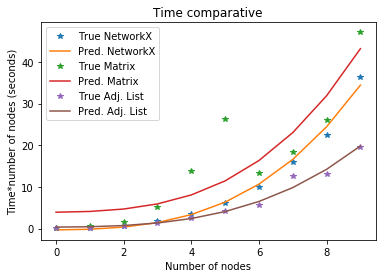

In [23]:
n_graphs=20
n_nodes_ini=10 
n_nodes_fin=100
step=10
sparse_f= 0.25
l_t_nx = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
l_t_m = time_dijkstra_m(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

fit_plot(l_t_nx, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="NetworkX")
fit_plot(l_t_m, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="Matrix")
fit_plot(l_t_d, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="Adj. List")